In [6]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import FunctionTransformer
from numpy import meshgrid
from pandas import datetime
## For plotting
import matplotlib.pyplot as plt
from matplotlib import style
import datetime as dt
import seaborn as sns
sns.set_style("whitegrid")


In [20]:
# processing data, removing the space in coumn names
total_data= pd.read_csv('../data/total_df.csv')
new_name = [name.strip() for name in total_data.columns]
total_data.columns = new_name
total_data = total_data.sort_values(by='Date')

#extract features to use
sub_feature = ['Date','Open','Close','bond','fed funds','fed total assets']
total_data = total_data[sub_feature]


total_data=total_data.iloc[:10000]

#change the columns names for fitting prophet()
total_data.columns = ['ds','x','y','bond','fed funds','fed total assets']
 


total_data
startDate = datetime(1978,1,3)
endDate = datetime(2018,1,17)
#Import data for Microsoft Stocks


,ds,x,y,bond,fed funds,fed total assets
10676,1978-01-03,93.82,93.82,7.83,6.70,720761.0
10675,1978-01-04,93.52,93.52,7.82,6.70,720761.0
10674,1978-01-05,92.74,92.74,7.83,6.70,720761.0
10673,1978-01-06,91.62,91.62,7.85,6.70,720761.0
10672,1978-01-09,90.64,90.64,8.01,6.70,720761.0
...,...,...,...,...,...,...
681,2018-01-10,2745.55,2748.23,2.55,1.41,4443718.0
680,2018-01-11,2752.97,2767.56,2.54,1.41,4446062.0
679,2018-01-12,2770.18,2786.24,2.55,1.41,4446062.0
678,2018-01-16,2798.96,2776.42,2.54,1.41,4446062.0


In [12]:
#feature normalization

normal_constants = []

for col in total_data.columns[1:]:
    tmp_max = np.max(abs(total_data[col]))
    normal_constants.append(tmp_max)
    total_data[col]= total_data[col]/tmp_max

print(normal_constants)

print(total_data.head())
total_data.dtypes

[2798.96, 2802.56, 15.84, 19.1, 4516077.0]
               ds         x         y      bond  fed funds  fed total assets
10676  1978-01-03  0.033520  0.033477  0.494318   0.350785          0.159599
10675  1978-01-04  0.033412  0.033369  0.493687   0.350785          0.159599
10674  1978-01-05  0.033134  0.033091  0.494318   0.350785          0.159599
10673  1978-01-06  0.032734  0.032692  0.495581   0.350785          0.159599
10672  1978-01-09  0.032383  0.032342  0.505682   0.350785          0.159599


ds                   object
x                   float64
y                   float64
bond                float64
fed funds           float64
fed total assets    float64
dtype: object

In [17]:
dif = total_data['y'] - total_data['x']
dif_data = pd.DataFrame([total_data['ds'], dif]).T

n = 7 #Window Size
window = []

#Create a dataframe with a rolling window of size n
for r in range(n,len(dif_data.index)):
  frame = [dif_data.iloc[r]['ds'], dif_data.iloc[r]['Unnamed 0']]
  for w in range(1,n+1):
    frame.append(dif_data.iloc[r-w]['Unnamed 0'])
  window.append(frame)
windowed_data = pd.DataFrame(window)

display(windowed_data)

,0,1,2,3,4,5,6,7,8
0,1978-01-12,-0.000041,-0.000041,-0.000041,-0.000042,-0.000042,-0.000043,-0.000043,-0.000043
1,1978-01-13,-0.000041,-0.000041,-0.000041,-0.000041,-0.000042,-0.000042,-0.000043,-0.000043
2,1978-01-16,-0.000041,-0.000041,-0.000041,-0.000041,-0.000041,-0.000042,-0.000042,-0.000043
3,1978-01-17,-0.000041,-0.000041,-0.000041,-0.000041,-0.000041,-0.000041,-0.000042,-0.000042
4,1978-01-18,-0.000042,-0.000041,-0.000041,-0.000041,-0.000041,-0.000041,-0.000041,-0.000042
...,...,...,...,...,...,...,...,...,...
9988,2018-01-10,-0.000304,-0.001213,0.000540,0.002964,0.000422,0.004189,0.003079,-0.006779
9989,2018-01-11,0.003943,-0.000304,-0.001213,0.000540,0.002964,0.000422,0.004189,0.003079
9990,2018-01-12,0.004459,0.003943,-0.000304,-0.001213,0.000540,0.002964,0.000422,0.004189
9991,2018-01-16,-0.009327,0.004459,0.003943,-0.000304,-0.001213,0.000540,0.002964,0.000422


In [21]:
#Convert the data to binary values, where True is an increase in value and False is a decrease in value
binary_window = windowed_data[0]
win = windowed_data.drop(columns=0)
binary_window = pd.concat([binary_window,win.mask(win > 0, True).mask(win < 0, False)], axis=1)
display(binary_window)

,0,1,2,3,4,5,6,7,8
0,1978-01-12,False,False,False,False,False,False,False,False
1,1978-01-13,False,False,False,False,False,False,False,False
2,1978-01-16,False,False,False,False,False,False,False,False
3,1978-01-17,False,False,False,False,False,False,False,False
4,1978-01-18,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...
9988,2018-01-10,False,False,True,True,True,True,True,False
9989,2018-01-11,True,False,False,True,True,True,True,True
9990,2018-01-12,True,True,False,False,True,True,True,True
9991,2018-01-16,False,True,True,False,False,True,True,True


2      3      4      5      6      7      8    
False  False  False  False  False  False  False    13
                                          True     13
                                   True   False    10
                                          True     11
                            True   False  False    21
                                                   ..
True   True   True   True   False  True   False     1
                                          True      1
                            True   False  False     5
                                          True      1
                                   True   False     2
Length: 127, dtype: int64

21
1


2      3      4      5      6      7      8    
False  False  False  False  False  False  False    7497
                                          True       12
                                   True   False      18
                                          True        7
                            True   False  False      12
                                                   ... 
True   True   True   True   False  True   True        9
                            True   False  False       9
                                          True        1
                                   True   False       4
                                          True        2
Length: 128, dtype: int64

7497
1


0     1
2     3     4     5     6     7     8              
False False False False False False False  13  True
                                    True   13  True
                              True  False  10  True
                                    True   11  True
                        True  False False  21  True
...                                        ..   ...
True  True  True  True  False True  False   1  True
                                    True    1  True
                        True  False False   5  True
                                    True    1  True
                              True  False   2  True

[127 rows x 2 columns]

0      1
2     3     4     5     6     7     8                 
False False False False False False False  7497  False
                                    True     12  False
                              True  False    18  False
                                    True      7  False
                        True  False False    12  False
...                                         ...    ...
True  True  True  True  False True  True      9  False
                        True  False False     9  False
                                    True      1  False
                              True  False     4  False
                                    True      2  False

[128 rows x 2 columns]

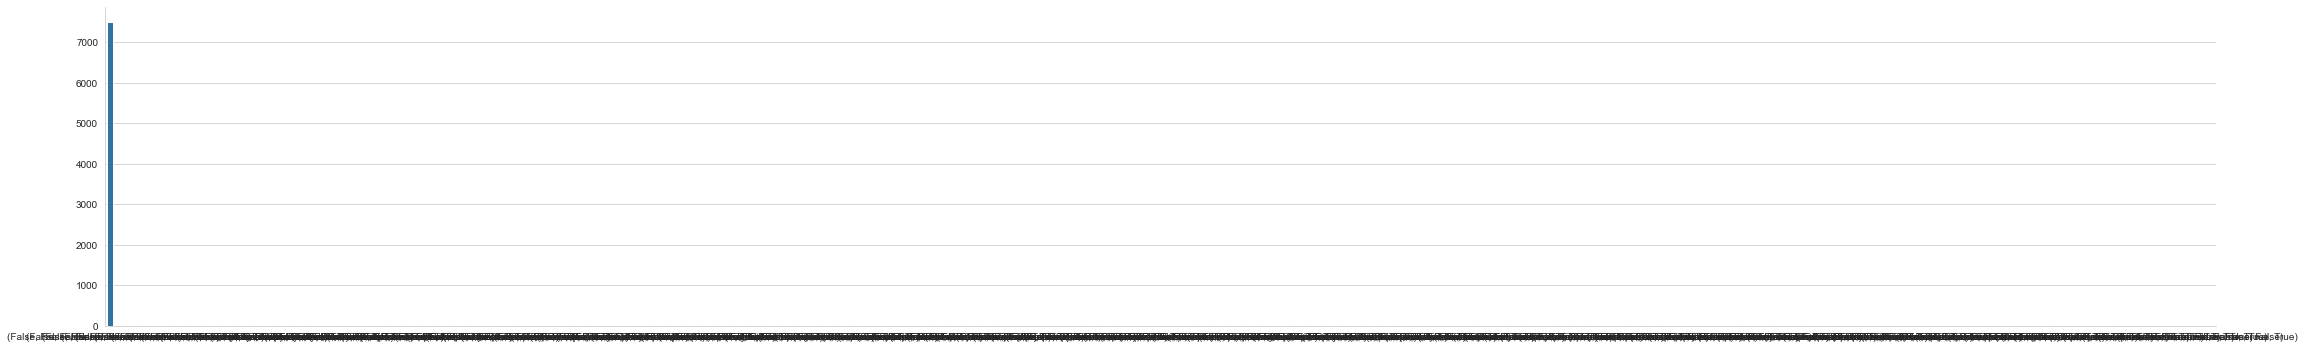

In [22]:
# This section groups windows by their combination of truth values, creates 256
# unique combinations with a window size of 7. This shouldn't be run with higher
# window sizes for performance reasons.

bin_win = binary_window.drop(columns=[0])
bin_win_true = bin_win[bin_win[1] == True].drop(columns=1)
bin_win_true = bin_win_true.groupby(bin_win_true.columns.tolist(),as_index=False).size()
bin_win_false = bin_win[bin_win[1] == False].drop(columns=1)
bin_win_false = bin_win_false.groupby(bin_win_false.columns.tolist(),as_index=False).size()

display(bin_win_true)
print(bin_win_true.max())
print(bin_win_true.min())
display(bin_win_false)
print(bin_win_false.max())
print(bin_win_false.min())

bin_win_true = pd.concat([bin_win_true,bin_win_true >= 0],axis=1)
bin_win_false = pd.concat([bin_win_false, bin_win_false < 0],axis=1)

display(bin_win_true)
display(bin_win_false)

chart = pd.concat([bin_win_true,bin_win_false],axis=0)

import seaborn
#Seaborn has an issue with data a boolean array; try block just hides exception messages
try:
  fg = seaborn.catplot(x=chart.index, y=0, hue=1, 
                        data=chart, kind='bar', height=5, aspect=6)
except:
  print("")

In [23]:
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB, BernoulliNB

y = windowed_data[1] > 0
X = windowed_data.drop(columns=[0,1])

#Split is determined randomly each time this block is run; rerun to see various 50/50 splits
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5)

Xb_train = X_train > 0
Xb_test = X_test > 0

gnb = GaussianNB()
bnb = BernoulliNB()
y_pred = gnb.fit(X_train, y_train).predict(X_test)
print("Gaussian: Number of mislabeled points out of a total %d points : %d"
       % (X_test.shape[0], (y_test != y_pred).sum()))
print("Accuracy: ", (y_test == y_pred).sum()/X_test.shape[0])
yb_pred = bnb.fit(Xb_train, y_train).predict(Xb_test)
print("Bernoulli: Number of mislabeled points out of a total %d points : %d"
       % (Xb_test.shape[0], (y_test != yb_pred).sum()))
print("Accuracy: ", (y_test == yb_pred).sum()/Xb_test.shape[0])

Gaussian: Number of mislabeled points out of a total 4997 points : 612
Accuracy:  0.8775265159095458
Bernoulli: Number of mislabeled points out of a total 4997 points : 673
Accuracy:  0.865319191514909
